In [1]:
import numpy as np
from tqdm import tqdm

from system import (
    rows,
    cols,
    states,
    s_state,
    t_state,
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
)
from model import Model
from policy import Policy, PolicyInit, ch_egreedy
from agent import Agent

In [2]:
def Egreedy_geneps(T: int, eps, Q_val: np.ndarray, start_state: np.ndarray, model: Model):
        estate = [start_state]
        start_action = ch_egreedy(eps, Q_val, start_state)
        eaction = [start_action]
        ereward = [
            model.get_reward(
                start_state, model.gen_next(start_state, start_action)
            )
        ]
        for i in range(T):
            estate.append(model.gen_next(estate[-1], eaction[-1], astuple=True))
            eaction.append(ch_egreedy(eps, Q_val, estate[-1]))
            ereward.append(model.get_reward(estate[-2], estate[-1]))
            if ereward[-1] == model.get_reward(estate[-2], t_state):
                break
        return estate, eaction, ereward

In [4]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [323]:

Q_val = np.random.uniform(-10, -1, (num_states, num_actions))
episodic_reward = []
Qvconverge = []

gamma = 0.9
epsilon = 0.4
alpha = 0.05
avg_factor = 0.9999
for i in tqdm(range(50000)):
    state = s_state
    T = 10000
    estates, eactions, erewards = Egreedy_geneps(T, epsilon, Q_val, tuple(state), model)
    T = len(estates) # Early termination

    fo = {}
    for j in range(T):
        s = tuple(estates[j])
        a = eactions[j]
        # r = erewards[j]
        if (s, a) not in fo:
            fo[(s, a)] = j
    g = 0
    
    for j in range(T):
        s = tuple(estates[T - j - 1])
        a = eactions[T - j - 1]
        r = erewards[T - j - 1]
        g = gamma * g + r
        if T - j - 1 == fo[(s, a)]:
            Q_val[to_idx(s)][a] = Q_val[to_idx(s)][a] + alpha*(g - Q_val[to_idx(s)][a])
    
    # epsilon = epsilon * 0.99 
    alpha = alpha * avg_factor
    Qvconverge.append(Q_val[to_idx(s_state)][4])
    episodic_reward.append(g)


100%|██████████| 50000/50000 [02:32<00:00, 327.46it/s]


In [324]:
valf = []
for s in states: 
    valid_actions = get_valid_actions(s)
    valf.append(np.max(Q_val[to_idx(s)][valid_actions]))
valf = np.array(valf)

for s in states: 
    valid_actions = get_valid_actions(s)
    action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
    policy.set_action(s, action)
agent.change_policy(policy)

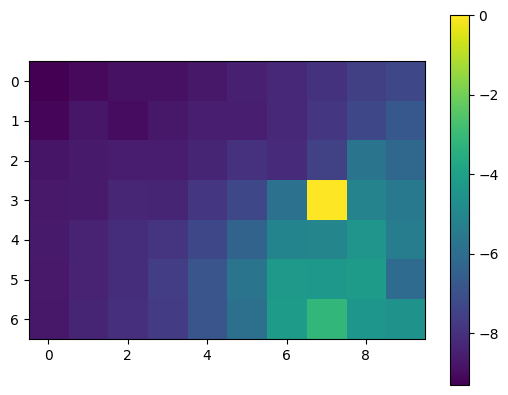

In [325]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

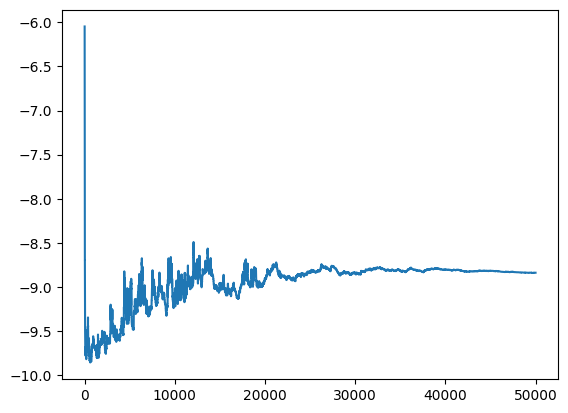

In [326]:
Qvconvergence = np.array(Qvconverge)
plt.plot(Qvconvergence)

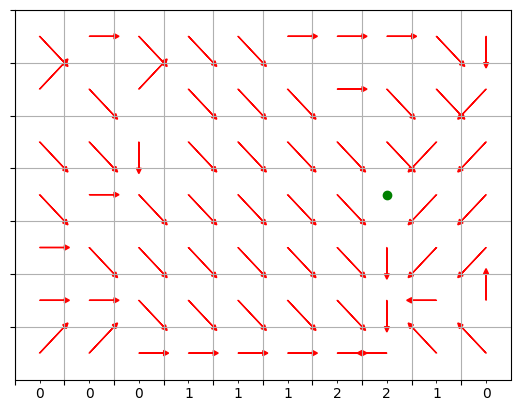

In [327]:
ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

# ## plot 8 types arrows in each grid cell corresponding to the action in the optimal policy
# 0: up-left, 1:up, 2: up-right, 3: left,4: right,5:down-left,6:down,7:down-right
for i in range(rows):
    for j in range(cols):
        s = np.array([i, j])
        # if i == t_state[0] and j == t_state[1]:
        #     continue
        action = policy.get_action(s)
        x_start = j + 0.5  # x-coordinate shifted to the middle of the grid cell
        y_start = i + 0.5  # y-coordinate shifted to the middle of the grid cell
        
        if action == 0:
            plt.arrow(x_start, y_start, -0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 1:
            plt.arrow(x_start, y_start, 0, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 2:
            plt.arrow(x_start, y_start, 0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 3:
            plt.arrow(x_start, y_start, -0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 4:
            plt.arrow(x_start, y_start, 0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 5:
            plt.arrow(x_start, y_start, -0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 6:
            plt.arrow(x_start, y_start, 0, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 7:
            plt.arrow(x_start, y_start, 0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 8:
            plt.plot(x_start, y_start, 'go')            

In [328]:
print(valf[to_idx(s_state)])

-8.65534628782667


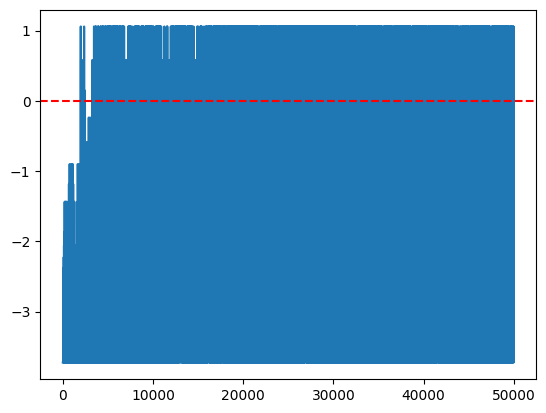

In [329]:
ecreward = np.load("OptimalValueFunction.npy")
episodic_regret = episodic_reward - ecreward[to_idx(s_state)]
plt.plot(episodic_regret)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

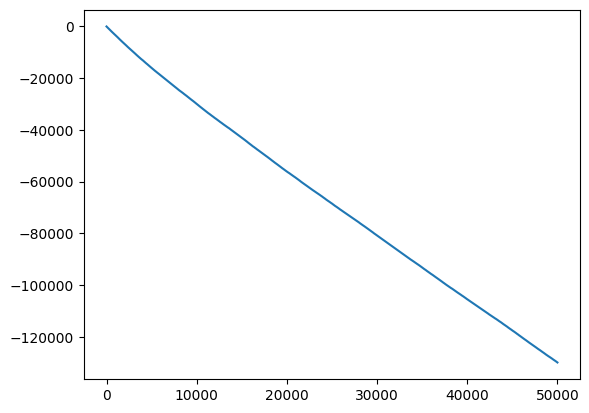

In [330]:
cummulative_regret = np.cumsum(episodic_regret)
plt.plot(cummulative_regret)
plt.show()

In [331]:
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [1 1], Next State: [6 3], Reward: -1
State: [6 3], Action: [0 1], Next State: [6 4], Reward: -1
State: [6 4], Action: [0 1], Next State: [5 5], Reward: -1
State: [5 5], Action: [1 1], Next State: [4 6], Reward: -1
State: [4 6], Action: [1 1], Next State: [3 7], Reward: 0
Game Over - Score: -6


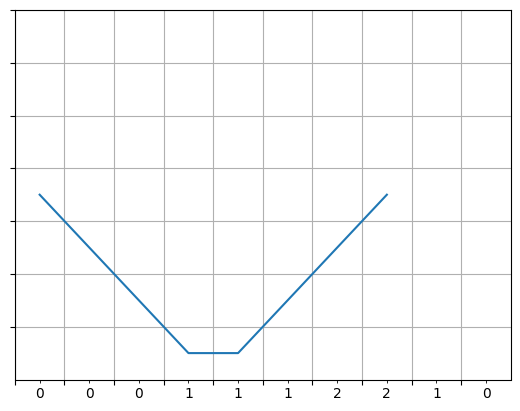

In [332]:

path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()